In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import scipy.signal as sig
from scipy.signal import tf2zpk
from scipy.spatial.transform import Rotation as R

path_ecg = "../../data"


def plot_imu_frame(axis_length=1.0, arrow_ratio=0.1):
    """
    Dibuja el sistema de coordenadas de una IMU en 3D.

    Parámetros:
    - axis_length: longitud de cada eje.
    - arrow_ratio: fracción del eje destinada a la cabeza de la flecha.
    """
    # Creamos la figura y el eje 3D
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Origen de los ejes
    origin = np.array([0, 0, 0])

    # Vectores unitarios para X, Y, Z
    axes = np.eye(3) * axis_length
    colors = ["r", "g", "b"]
    labels = ["N", "Y", "-g"]

    # Dibujar cada eje con quiver (flecha)
    for vec, c, lab in zip(axes, colors, labels):
        ax.quiver(
            origin[0],
            origin[1],
            origin[2],
            vec[0],
            vec[1],
            vec[2],
            color=c,
            arrow_length_ratio=arrow_ratio,
            linewidth=2,
        )
        # Etiquetar el extremo del eje
        ax.text(
            vec[0] * 1.05,
            vec[1] * 1.05,
            vec[2] * 1.05,
            lab,
            color=c,
            fontsize=14,
            fontweight="bold",
        )

    # Ajustes de estilo
    ax.set_xlim(0, axis_length * 1.2)
    ax.set_ylim(0, axis_length * 1.2)
    ax.set_zlim(0, axis_length * 1.2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Sistema de coordenadas IMU")
    ax.grid(True)

    # Mostrar proporción igual para los tres ejes
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()


def calcular_relacion_romberg(
    param_eyes_open: float,
    param_eyes_close: float,
) -> float:
    return param_eyes_close / param_eyes_open


def calcular_rms(signal1):
    return np.sqrt(np.mean(np.square(signal1)))


def calcular_magnitud_angular_velocity(df):
    """
    Calcula la magnitud del vector de aceleración global y la agrega al DataFrame.
    """
    df["Gyr_Global_Mag"] = np.sqrt(
        df["Gyr_X_global"] ** 2 + df["Gyr_Y_global"] ** 2 + df["Gyr_Z_global"] ** 2
    )
    return df.copy()


def calcular_magnitud_aceleracion_local(df):
    """
    Calcula la magnitud del vector de aceleración global y la agrega al DataFrame.
    """
    df["Acc_Local_Mag"] = np.sqrt(df["Acc_Y"] ** 2 + df["Acc_Z"] ** 2)
    return df.copy()


def calcular_magnitud_aceleracion(df):
    """
    Calcula la magnitud del vector de aceleración global y la agrega al DataFrame.
    """
    df["Acc_Global_Mag"] = np.sqrt(df["Acc_X_global"] ** 2 + df["Acc_Y_global"] ** 2)
    return df.copy()


def CalculateGlobalVectors(df):
    # Cuaterniones y aceleración local
    quaternions = df[["Quat_q0", "Quat_q1", "Quat_q2", "Quat_q3"]].values
    acc_local = df[["Acc_X", "Acc_Y", "Acc_Z"]].values
    ang_vel_local = df[["Gyr_X", "Gyr_Y", "Gyr_Z"]].values

    sig_filtersos = sig.butter(10, 4, "low", fs=100, output="sos")

    # Aplicar filtro a las columnas de aceleración
    acc_local = sig.sosfilt(sig_filtersos, acc_local)
    ang_vel_local = sig.sosfilt(sig_filtersos, ang_vel_local)
    df[["Acc_X", "Acc_Y", "Acc_Z"]] = acc_local
    df[["Gyr_X", "Gyr_Y", "Gyr_Z"]] = ang_vel_local

    # Rotar aceleraciones al sistema global
    rot = R.from_quat(quaternions)
    acc_global = rot.apply(acc_local)
    ang_vel_global = rot.apply(ang_vel_local)

    # 🔁 Normalizar Y y Z a máximo absoluto de 1
    # acc_global[:, 1] = acc_global[:, 1] / np.max(np.abs(acc_global[:, 1]))
    # acc_global[:, 2] = acc_global[:, 2] / np.max(np.abs(acc_global[:, 2]))

    # Guardar aceleraciones normalizadas
    df["Acc_X_global"] = sig.sosfilt(sig_filtersos, acc_global[:, 0])
    df["Acc_Y_global"] = sig.sosfilt(sig_filtersos, acc_global[:, 1])
    df["Acc_Z_global"] = sig.sosfilt(sig_filtersos, acc_global[:, 2])
    df["Gyr_X_global"] = sig.sosfilt(sig_filtersos, ang_vel_global[:, 0])
    df["Gyr_Y_global"] = sig.sosfilt(sig_filtersos, ang_vel_global[:, 1])
    df["Gyr_Z_global"] = sig.sosfilt(sig_filtersos, ang_vel_global[:, 2])
    return df.copy()


def select_mid_segment(
    df: pd.DataFrame,
    time_col: str = "Time",
    half_length: float = 10.0,
) -> pd.DataFrame:
    """
    Selecciona el segmento de df que comprende `pre_sec` segundos
    antes y `post_sec` segundos después del punto medio de la serie
    temporal indicada por `time_col`.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que debe contener la columna de tiempo `time_col`.
    time_col : str
        Nombre de la columna de tiempo (en segundos).
    pre_sec : float
        Segundos a incluir antes del punto medio.
    post_sec : float
        Segundos a incluir después del punto medio.

    Devuelve
    -------
    pd.DataFrame
        Sub-DataFrame con las mismas columnas que `df`, filtrado
        para el intervalo [midpoint - pre_sec, midpoint + post_sec].
    """
    # Calcular extremo inferior y superior del tiempo
    t_min = df[time_col].min()
    t_max = df[time_col].max()
    midpoint = (t_min + t_max) / 2

    start_time = midpoint - half_length
    end_time = midpoint + half_length

    # Filtrar el DataFrame por el rango de tiempo
    segment = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)].copy()

    return segment


dataDualTask = pd.read_csv(
    "data/BalanceAssessment/KMartinez/Xsens/TUG/dt_01_01200628_000-000.txt",
    sep="\t",
    skiprows=12,
)
dataEyeClosed = pd.read_csv(
    "data/BalanceAssessment/KMartinez/Xsens/TUG/ec_01_01200628_000-000.txt",
    sep="\t",
    skiprows=12,
)
dataEyeOpen = pd.read_csv(
    "data/BalanceAssessment/KMartinez/Xsens/TUG/eo_01_01200628_000-000.txt",
    sep="\t",
    skiprows=12,
)
dataEyeClosed = dataEyeClosed.drop(columns=["PacketCounter", "SampleTimeFine"])
dataDualTask = dataDualTask.drop(columns=["PacketCounter", "SampleTimeFine"])
dataEyeOpen = dataEyeOpen.drop(columns=["PacketCounter", "SampleTimeFine"])
fs = 100
Ts = 1 / fs
dataEyeOpen["Time"] = Ts * np.arange(0, len(dataEyeOpen))
dataEyeClosed["Time"] = Ts * np.arange(0, len(dataEyeClosed))
dataDualTask["Time"] = Ts * np.arange(0, len(dataDualTask))
dataDualTask = CalculateGlobalVectors(dataDualTask)
dataEyeClosed = CalculateGlobalVectors(dataEyeClosed)
dataEyeOpen = CalculateGlobalVectors(dataEyeOpen)

dataDualTask = calcular_magnitud_aceleracion(dataDualTask)
dataEyeClosed = calcular_magnitud_aceleracion(dataEyeClosed)
dataEyeOpen = calcular_magnitud_aceleracion(dataEyeOpen)

dataDualTask = calcular_magnitud_aceleracion_local(dataDualTask)
dataEyeClosed = calcular_magnitud_aceleracion_local(dataEyeClosed)
dataEyeOpen = calcular_magnitud_aceleracion_local(dataEyeOpen)

dataDualTask = calcular_magnitud_angular_velocity(dataDualTask)
dataEyeClosed = calcular_magnitud_angular_velocity(dataEyeClosed)
dataEyeOpen = calcular_magnitud_angular_velocity(dataEyeOpen)

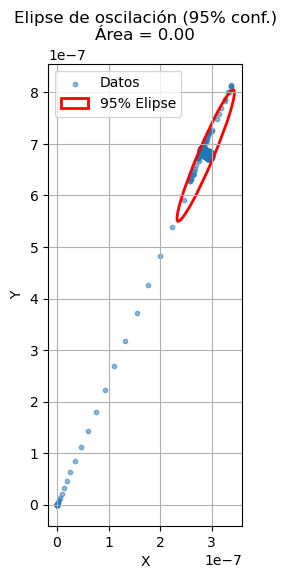

Área de la elipse al 95 %: 0.0000
Semiejes: a=0.00, b=0.00, ángulo=67.1°


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2


def ellipse_sway_area(x, y, confidence=0.95, plot=True):
    """
    Calcula el área y dibuja la elipse de oscilación para los datos (x,y)
    cubriendo el porcentaje de confianza dado (p.ej. 0.95 para 95%).

    Parámetros:
    - x, y: arrays de coordenadas (misma longitud).
    - confidence: nivel de confianza (entre 0 y 1).
    - plot: si True, dibuja los puntos y la elipse.

    Retorna:
    - area: área de la elipse.
    - width, height: semiejes mayor y menor.
    - angle: ángulo de rotación en grados.
    """
    # Centro (media)
    mu = np.array([np.mean(x), np.mean(y)])
    # Matriz de covarianza
    cov = np.cov(x, y)
    # Eigenvalores y eigenvectores
    vals, vecs = np.linalg.eigh(cov)
    # Ordenar de mayor a menor
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Factor de escala: chi-cuadrado inverso para 2 grados y nivel dado
    chi2_val = chi2.ppf(confidence, df=2)
    # Semiejes
    a = np.sqrt(vals[0] * chi2_val)
    b = np.sqrt(vals[1] * chi2_val)
    area = np.pi * a * b

    # Ángulo de rotación (en grados) del semieje mayor respecto al eje X
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(x, y, s=10, alpha=0.5, label="Datos")
        # Dibujo de la elipse
        from matplotlib.patches import Ellipse

        ellipse = Ellipse(
            xy=mu,
            width=2 * a,
            height=2 * b,
            angle=angle,
            edgecolor="r",
            facecolor="none",
            lw=2,
            label=f"{int(confidence*100)}% Elipse",
        )
        ax.add_patch(ellipse)
        ax.set_aspect("equal")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_title(
            f"Elipse de oscilación ({int(confidence*100)}% conf.)\nÁrea = {area:.2f}"
        )
        ax.legend()
        plt.grid(True)
        plt.show()

    return area, a, b, angle


# Ejemplo de uso:
if __name__ == "__main__":
    # Simulamos datos de sway
    np.random.seed(0)
    x = np.random.normal(0, 1, size=500)
    y = 0.5 * x + np.random.normal(0, 0.8, size=500)

    area, a, b, angle = ellipse_sway_area(
        dataDualTask["Acc_X_global"], dataDualTask["Acc_Y_global"], confidence=0.95
    )
    print(f"Área de la elipse al 95 %: {area:.4f}")
    print(f"Semiejes: a={a:.2f}, b={b:.2f}, ángulo={angle:.1f}°")

In [3]:
rmsAccX_eo = calcular_rms(dataEyeOpen["Acc_X_global"])
rmsAccY_eo = calcular_rms(dataEyeOpen["Acc_Y_global"])
rmsAccZ_eo = calcular_rms(dataEyeOpen["Acc_Z_global"])

rmsGyrX_eo = calcular_rms(dataEyeOpen["Gyr_X_global"])
rmsGyrY_eo = calcular_rms(dataEyeOpen["Gyr_Y_global"])
rmsGyrZ_eo = calcular_rms(dataEyeOpen["Gyr_Z_global"])

pathTrajectAcc_eo = np.sum(dataEyeOpen["Acc_Local_Mag"])
areaAcc_eo, a, b, angle = ellipse_sway_area(
    dataEyeOpen["Acc_X_global"],
    dataEyeOpen["Acc_Y_global"],
    confidence=0.95,
    plot=False,
)

In [4]:
rmsAccX_ec = calcular_rms(dataEyeClosed["Acc_X_global"])
rmsAccY_ec = calcular_rms(dataEyeClosed["Acc_Y_global"])
rmsAccZ_ec = calcular_rms(dataEyeClosed["Acc_Z_global"])

rmsGyrX_ec = calcular_rms(dataEyeClosed["Gyr_X_global"])
rmsGyrY_ec = calcular_rms(dataEyeClosed["Gyr_Y_global"])
rmsGyrZ_ec = calcular_rms(dataEyeClosed["Gyr_Z_global"])

pathTrajectAcc_ec = np.sum(dataEyeClosed["Acc_Local_Mag"])
areaAcc_ec, a, b, angle = ellipse_sway_area(
    dataEyeClosed["Acc_X_global"],
    dataEyeClosed["Acc_Y_global"],
    confidence=0.95,
    plot=False,
)

In [5]:
rmsAccX_dt = calcular_rms(dataDualTask["Acc_X_global"])
rmsAccY_dt = calcular_rms(dataDualTask["Acc_Y_global"])
rmsAccZ_dt = calcular_rms(dataDualTask["Acc_Z_global"])

rmsGyrX_dt = calcular_rms(dataDualTask["Gyr_X_global"])
rmsGyrY_dt = calcular_rms(dataDualTask["Gyr_Y_global"])
rmsGyrZ_dt = calcular_rms(dataDualTask["Gyr_Z_global"])

pathTrajectAcc_dt = np.sum(dataDualTask["Acc_Local_Mag"])
areaAcc_dt, a, b, angle = ellipse_sway_area(
    dataDualTask["Acc_X_global"], dataDualTask["Acc_Y_global"], confidence=0.95,plot=False
)

In [6]:
rmsAccX_dt = calcular_rms(dataDualTask["Acc_X_global"])
rmsAccY_dt = calcular_rms(dataDualTask["Acc_Y_global"])
rmsAccZ_dt = calcular_rms(dataDualTask["Acc_Z_global"])

rmsGyrX_dt = calcular_rms(dataDualTask["Gyr_X_global"])
rmsGyrY_dt = calcular_rms(dataDualTask["Gyr_Y_global"])
rmsGyrZ_dt = calcular_rms(dataDualTask["Gyr_Z_global"])

pathTrajectAcc_dt = np.sum(dataDualTask["Acc_Local_Mag"])
areaAcc_dt, a, b, angle = ellipse_sway_area(
    dataDualTask["Acc_X_global"],
    dataDualTask["Acc_Y_global"],
    confidence=0.95,
    plot=False,
)

rmsAccX_ec = calcular_rms(dataEyeClosed["Acc_X_global"])
rmsAccY_ec = calcular_rms(dataEyeClosed["Acc_Y_global"])
rmsAccZ_ec = calcular_rms(dataEyeClosed["Acc_Z_global"])

rmsGyrX_ec = calcular_rms(dataEyeClosed["Gyr_X_global"])
rmsGyrY_ec = calcular_rms(dataEyeClosed["Gyr_Y_global"])
rmsGyrZ_ec = calcular_rms(dataEyeClosed["Gyr_Z_global"])

pathTrajectAcc_ec = np.sum(dataEyeClosed["Acc_Local_Mag"])
areaAcc_ec, a, b, angle = ellipse_sway_area(
    dataEyeClosed["Acc_X_global"],
    dataEyeClosed["Acc_Y_global"],
    confidence=0.95,
    plot=False,
)

rmsAccX_eo = calcular_rms(dataEyeOpen["Acc_X_global"])
rmsAccY_eo = calcular_rms(dataEyeOpen["Acc_Y_global"])
rmsAccZ_eo = calcular_rms(dataEyeOpen["Acc_Z_global"])

rmsGyrX_eo = calcular_rms(dataEyeOpen["Gyr_X_global"])
rmsGyrY_eo = calcular_rms(dataEyeOpen["Gyr_Y_global"])
rmsGyrZ_eo = calcular_rms(dataEyeOpen["Gyr_Z_global"])

pathTrajectAcc_eo = np.sum(dataEyeOpen["Acc_Local_Mag"])
areaAcc_eo, a, b, angle = ellipse_sway_area(
    dataEyeOpen["Acc_X_global"],
    dataEyeOpen["Acc_Y_global"],
    confidence=0.95,
    plot=False,
)